In [6]:
from pyspark.sql.functions import *
import pyspark as ps
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
import numpy as np
import os
import json
import glob

In [43]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df capstone") \
            .getOrCreate()

spark

In [ ]:
# dframe = spark.read.json('./data/mpd.slice.0-999.json', multiLine=True)
# playlist = dframe.head()[1]
# single_playlist = playlist[0]
# #column_names = single_playlist.__fields__


In [44]:
column_names = ['collaborative',
 'description',
 'duration_ms',
 'modified_at',
 'name',
 'num_albums',
 'num_artists',
 'num_edits',
 'num_followers',
 'num_tracks',
 'pid',
 'tracks']


In [45]:
path_to_json = "./data/"
json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern)

In [16]:
#file_list[:3]

['./data/mpd.slice.0-999.json',
 './data/mpd.slice.1000-1999.json',
 './data/mpd.slice.10000-10999.json']

## problem area -> 

In [46]:
list_of_frames = []
for file in file_list[:20]: 
    current_df = spark.read.json(file, multiLine=True)
    current_playlist = current_df.head()[1]
    current_pframe = pd.DataFrame(current_playlist, columns=column_names)
    list_of_frames.append(current_pframe)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


Py4JError: An error occurred while calling o234.json

In [18]:
result = pd.concat(list_of_frames)

In [19]:
result.set_index('pid', inplace=True)

In [24]:
df = result.drop('tracks', axis=1).copy()
df.drop('name', axis=1, inplace=True)
df.drop('description', axis=1, inplace=True)
df.drop('modified_at', axis=1, inplace=True)

In [15]:
# COLUMNS OF INTEREST ISOLATED INTO CLEAN FRAME IN 'df' VARIABLE:


In [25]:
df.to_csv('ten_k_playlists.csv')

In [ ]:
## save result as pandas file for easy calling later

In [26]:
df

,collaborative,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks
pid,,,,,,,
0,false,11532414,47,37,6,1,52
1,false,11656470,23,21,5,1,39
2,false,14039958,51,31,18,1,64
3,false,28926058,107,86,4,1,126
4,false,4335282,16,16,7,2,17
...,...,...,...,...,...,...,...
106995,false,11940399,37,28,7,1,45
106996,false,9693810,41,43,2,1,46
106997,false,3820856,13,13,2,1,13


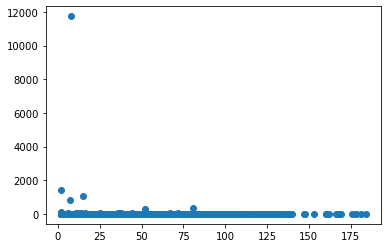

In [27]:
# comparing number of edits to number of followers. Data does not look interesting. 
plt.scatter(df.num_edits, df.num_followers)

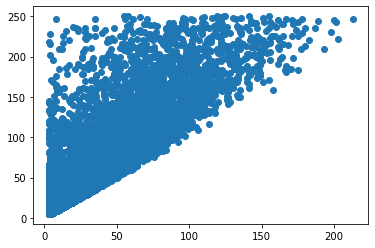

In [28]:
#comparing number of artists to number of tracks (playlist diversity?) - seems interesting, consistent ratio? 
plt.scatter(df.num_artists, df.num_tracks)
#explore plotting the line of completely diverse songs
#entropy of a group: think of a way to score the diversity numerically? (distance from the 1:1 ratio line, or, more simply: ratio of artists to tracks)

(array([2974., 2369., 1547.,  965.,  683.,  456.,  368.,  278.,  206.,
         154.]),
 array([  5. ,  29.5,  54. ,  78.5, 103. , 127.5, 152. , 176.5, 201. ,
        225.5, 250. ]),
 <BarContainer object of 10 artists>)

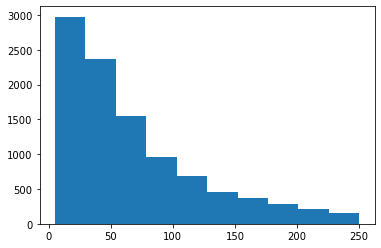

In [29]:
#looking at number of tracks
plt.hist(df.num_tracks)

(array([4027., 2853., 1500.,  831.,  409.,  209.,  104.,   45.,   16.,
           6.]),
 array([  3.,  24.,  45.,  66.,  87., 108., 129., 150., 171., 192., 213.]),
 <BarContainer object of 10 artists>)

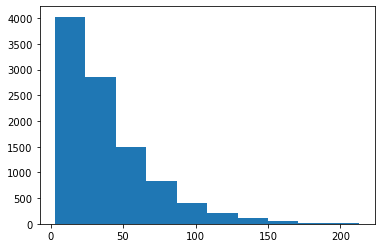

In [30]:
#looking at number of artists per playlist
plt.hist(df.num_artists)

In [31]:
df['diversity_ratio'] = df['num_artists'] / df['num_tracks']

In [32]:
df

,collaborative,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks,diversity_ratio
pid,,,,,,,,
0,false,11532414,47,37,6,1,52,0.711538
1,false,11656470,23,21,5,1,39,0.538462
2,false,14039958,51,31,18,1,64,0.484375
3,false,28926058,107,86,4,1,126,0.682540
4,false,4335282,16,16,7,2,17,0.941176
...,...,...,...,...,...,...,...,...
106995,false,11940399,37,28,7,1,45,0.622222
106996,false,9693810,41,43,2,1,46,0.934783
106997,false,3820856,13,13,2,1,13,1.000000


In [33]:
df.to_csv('ten_k_playlists.csv')

(array([ 209.,  285.,  447.,  723., 1033., 1355., 1619., 1684., 1451.,
        1194.]),
 array([0.01376147, 0.11238532, 0.21100917, 0.30963303, 0.40825688,
        0.50688073, 0.60550459, 0.70412844, 0.80275229, 0.90137615,
        1.        ]),
 <BarContainer object of 10 artists>)

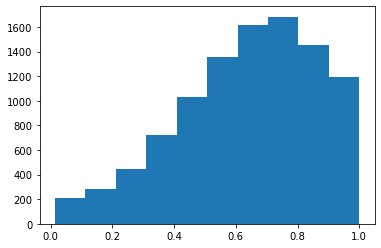

In [34]:
plt.hist(df.diversity_ratio)

In [35]:
df.corr()

,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks,diversity_ratio
duration_ms,1.000000,0.895163,0.809242,0.612631,-0.005156,0.985170,-0.389646
num_albums,0.895163,1.000000,0.955091,0.678607,-0.004305,0.904298,-0.116220
num_artists,0.809242,0.955091,1.000000,0.666449,-0.003182,0.823649,0.060278
num_edits,0.612631,0.678607,0.666449,1.000000,-0.002572,0.617200,-0.063053
num_followers,-0.005156,-0.004305,-0.003182,-0.002572,1.000000,-0.004579,0.001421
num_tracks,0.985170,0.904298,0.823649,0.617200,-0.004579,1.000000,-0.389024
diversity_ratio,-0.389646,-0.116220,0.060278,-0.063053,0.001421,-0.389024,1.000000


<AxesSubplot:>

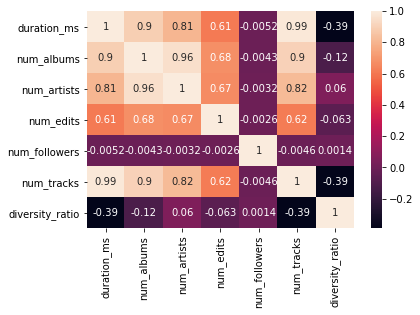

In [36]:
sn.heatmap(df.corr(), annot=True)

### planning: 
- null hypothesis: Playlist diversity ratio has no effect on number of followers
- can compare the diference between the "high follower" set and the "low follower" set to see if diversity ratio influences follower count
- t-test to see if you can confidently reject the null-hypothesis

In [37]:
less_than = df[df['num_followers'] < 20]
less_than

,collaborative,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks,diversity_ratio
pid,,,,,,,,
0,false,11532414,47,37,6,1,52,0.711538
1,false,11656470,23,21,5,1,39,0.538462
2,false,14039958,51,31,18,1,64,0.484375
3,false,28926058,107,86,4,1,126,0.682540
4,false,4335282,16,16,7,2,17,0.941176
...,...,...,...,...,...,...,...,...
106995,false,11940399,37,28,7,1,45,0.622222
106996,false,9693810,41,43,2,1,46,0.934783
106997,false,3820856,13,13,2,1,13,1.000000


In [39]:
greater_equal = df[df['num_followers'] >= 20]
greater_equal

,collaborative,duration_ms,num_albums,num_artists,num_edits,num_followers,num_tracks,diversity_ratio
pid,,,,,,,,
255,false,6772221,28,25,3,22,32,0.781250
765,false,15112167,37,59,15,1038,81,0.728395
1311,false,9156237,39,33,2,20,39,0.846154
1750,false,3938462,12,8,2,87,14,0.571429
1907,false,9820628,38,37,25,82,45,0.822222
1923,false,38583631,64,51,13,23,196,0.260204
100239,false,12629055,44,33,16,25,54,0.611111
100432,false,14983903,74,59,7,823,108,0.546296
100606,false,32896971,14,3,6,29,143,0.020979


In [27]:
less_than_mean = less_than.diversity_ratio.mean()
less_than_mean

0.6386820910367528

In [28]:
greater_equal_mean = greater_equal.diversity_ratio.mean()
greater_equal_mean

0.6724998756095926

In [29]:
less_than_std = less_than.diversity_ratio.std()
less_than_std

0.2302076566364094

In [30]:
greater_equal_std = greater_equal.diversity_ratio.std()
greater_equal_std

0.2743546913898894

In [31]:
less_than_norm = stats.norm(less_than_mean, less_than_std)
greater_equal_norm = stats.norm(greater_equal_mean, greater_equal_std)

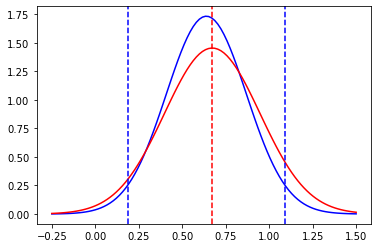

In [33]:
left_tail = less_than_norm.ppf(.025)
right_tail = less_than_norm.ppf(.975)


fig, ax = plt.subplots()
x = np.linspace(-0.25,1.5,100)
ax.plot(x, less_than_norm.pdf(x), color='blue')
ax.plot(x, greater_equal_norm.pdf(x), color='red')
ax.axvline(left_tail, color='blue', linestyle = 'dashed')
ax.axvline(right_tail, color='blue', linestyle='dashed')
ax.axvline(greater_equal_mean, color='red', linestyle='dashed')

#### run scipy.stats t-test to get p-value that backs up rejecting the null hypothesis
#### check to see if the diversity_ratio is normally distributed?? If no, bootstrapping for CLT sampling means